In [0]:
import argparse
import yaml
import time
import datetime
import cv2
import numpy as np
import pandas as pd
import random

from skimage import io, transform
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from scipy import ndimage, misc

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch
from torch.autograd import Variable
import torch.optim as optim

from google.colab import drive
import os
import warnings
from collections import defaultdict

In [0]:
drive.mount('/content/drive', force_remount = True)
BASE_DIR = '/content/drive/My Drive/Mosquito-Tec'
os.chdir(BASE_DIR)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
### Dataset functions

def paddedzoom(img, zoomfactor = 0.8):
    out  = np.zeros_like(img)
    zoomed = cv2.resize(img, None, fx = zoomfactor, fy = zoomfactor)
    
    h, w, _ = img.shape
    zh, zw, _ = zoomed.shape
    if zoomfactor<1:    
        out[int((h-zh)/2):int(-(h-zh)/2),int((w-zw)/2):int(-(w-zw)/2), :] = zoomed
    else:
        out = zoomed[int((zh-h)/2):int(-(zh-h)/2), int((zw-w)/2):int(-(zw-w)/2), :]

    return out

class SentinelDataset(Dataset):

    def __init__(self, csv_file, root_dir, training = True, transform = None):
        self.sentinel_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.training = training
        self.mean = np.array([[[0.0188]],[[0.0181]],[[0.0226]]])
        self.std =  np.array([[[0.0190]],[[0.0193]],[[0.0191]]])

    def __len__(self):
        return len(self.sentinel_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        filename = str('data' + str(self.sentinel_frame.iloc[idx, 0])+'.npy')

        img_name = os.path.join(self.root_dir, filename)
        image = np.load(img_name)[2:5].astype(np.float32) / 65536

        #normalization
        image /= image.max()

        if self.training:
            #random flip
            if np.random.rand() > 0.5:
                image = np.flip(image, axis=2).copy()

            #random rotate
            image = ndimage.rotate(image, random.randint(-20, 20), axes = [1,2], 
                                   reshape = False)

            # random zoom
            or_image = image.copy()
            image =  np.swapaxes(image,0,2)
            image = paddedzoom(image, 1.0 + (np.random.rand()/2) )
            image =  np.swapaxes(image,0,2)
            if image.shape != or_image.shape:
                image = or_image

        if self.transform:
            image = self.transform(image)

        target = self.sentinel_frame.iloc[idx, -1]
        image = torch.from_numpy(image)
        return image, target

In [0]:
def crop(x, th, tw):
        _, _, w, h = x.size()
        x1 = int(round((w - tw) / 2.))
        y1 = int(round((h - th) / 2.))
        return x[:, :, x1:x1 + tw, y1:y1 + th]

In [0]:
BATCH_SIZE = 32

sentinel_dataset = SentinelDataset(csv_file = '/content/drive/My Drive/Colab/mosquito/Final_Mosquito_train.csv',
                                    root_dir = '/content/drive/My Drive/Colab/mosquito/data_mosquito/', training = True)

sentinel_dataset_test = SentinelDataset(csv_file = '/content/drive/My Drive/Colab/mosquito/Final_Mosquito_test.csv',
                                    root_dir = '/content/drive/My Drive/Colab/mosquito/data_mosquito/', training = False)

train_loader = DataLoader(sentinel_dataset, batch_size = BATCH_SIZE, 
                              shuffle = True, num_workers = 1)

test_loader = DataLoader(sentinel_dataset_test, batch_size = BATCH_SIZE, 
                             shuffle = False, num_workers=1)

In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

torch.Size([32, 3, 104, 104])


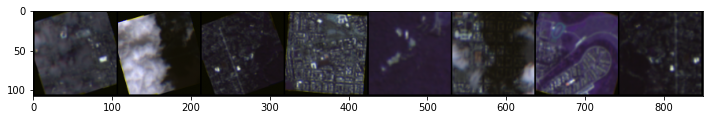

In [0]:
dataiter = iter(train_loader)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()
print(images.shape)

# show images
fig = plt.figure(figsize=(12, 8))
images = images[0:8, :, :, :]
images[:, 0, :, :] = torch.from_numpy(cv2.normalize(images[:, 0, :, :].numpy(), 
                                                    None, 0, 255, 
                                                    cv2.NORM_MINMAX, 
                                                    dtype = cv2.CV_8U) / 255.)
images[:, 1, :, :] = torch.from_numpy(cv2.normalize(images[:, 1, :, :].numpy(), 
                                                    None, 0, 255, 
                                                    cv2.NORM_MINMAX, 
                                                    dtype = cv2.CV_8U) / 255.)
images[:, 2, :, :] = torch.from_numpy(cv2.normalize(images[:, 2, :, :].numpy(), 
                                                    None, 0, 255, 
                                                    cv2.NORM_MINMAX, 
                                                    dtype = cv2.CV_8U) / 255.)

imshow(torchvision.utils.make_grid(images))

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

In [0]:
def get_flatten_output():
    model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 64, 4, 2),
        torch.nn.LeakyReLU(),
        torch.nn.Conv2d(64, 128, 4, 2),
        torch.nn.LeakyReLU(),
        Flatten(),
    )
    return model(Variable(torch.rand(2,1,28,28))).size()
get_flatten_output()

torch.Size([2, 3200])

In [0]:
def get_reshape_output():
    model = torch.nn.Sequential(
        torch.nn.Linear(2, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 7*7*128),
        torch.nn.ReLU(),
        Reshape((128,7,7,)),
        torch.nn.ConvTranspose2d(128, 64, 4, 2),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=3),
        torch.nn.Sigmoid()
    )
    return model(Variable(torch.rand(2,2))).size()
get_reshape_output()

torch.Size([2, 1, 28, 28])

In [0]:
# Encoder and decoder use the DC-GAN architecture
class Encoder(torch.nn.Module):
    def __init__(self, c, z_dim, n_latent):
        super(Encoder, self).__init__()
        self.model = torch.nn.ModuleList([
            nn.Conv2d(c, 32, 4, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 4, 2, padding=1),
            nn.LeakyReLU(),
            Flatten(),
            nn.Linear(64 * z_dim**2, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, n_latent)
        ])
        
    def forward(self, x):
        i = 1
        for layer in self.model:
            x = layer(x)
        return x
    
    
class Decoder(torch.nn.Module):
    def __init__(self, c, z_dim, n_latent):
        super(Decoder, self).__init__()
        self.model = torch.nn.ModuleList([
            nn.Linear(n_latent, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64 * z_dim**2),
            nn.ReLU(),
            Reshape((64, z_dim, z_dim,)),
            nn.ConvTranspose2d(64, 32, 4, 2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, c, 4, 2, padding=1),
            nn.Sigmoid()
        ])
        
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x

In [0]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2) / float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

In [0]:
class MMD_VAE(torch.nn.Module):
    def __init__(self, in_shape, n_latent):
        super(MMD_VAE, self).__init__()
        self.in_shape = in_shape
        self.n_latent = n_latent
        self.c, self.h, self.w = in_shape
        self.z_dim = self.h // 2**2
        self.encoder = Encoder(self.c, self.z_dim, self.n_latent)
        self.decoder = Decoder(self.c, self.z_dim, self.n_latent)
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        x_reconstructed = crop(x_reconstructed, self.h, self.h)
        return z, x_reconstructed

In [0]:
# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array 
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples

def train(epoch, model, loader, optimizer, device, logs_interval, n_latent):
    model.train()
    train_loss = 0

    for batch_idx, (inputs, _) in enumerate(loader):
        inputs = inputs.to(device)
        true_samples = Variable(
            torch.randn(200, n_latent),
            requires_grad = False
        ).to(device)

        z, output = model(inputs)
        mmd = compute_mmd(true_samples, z)
        nll = (output - inputs).pow(2).mean()
        loss = nll + mmd

        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()


        if batch_idx % logs_interval == 0:
            print("Negative log likelihood is {:.5f}, mmd loss is {:.5f}".format(
                    nll.item(), mmd.item()))
            
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(loader.dataset)))

In [0]:
# Model
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

n_latent = 50

model = MMD_VAE((3, 104, 104), n_latent = n_latent).to(device).double()
optimizer = torch.optim.Adam(model.parameters())
#optimizer = optim.RMSprop(model.parameters(), lr = 1e-4)

In [0]:
EPOCHS = 50

for epoch in range(1, EPOCHS + 1):
    train(epoch, model, train_loader, optimizer, device, 20, n_latent)
    if epoch % 10 == 0:
        torch.save({
            'iter': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            },
            os.path.join('./last_mmd_vae.ckpt'))   

Negative log likelihood is 0.09880, mmd loss is 0.00062
Negative log likelihood is 0.02472, mmd loss is 0.00066
Negative log likelihood is 0.01539, mmd loss is 0.00072
====> Epoch: 1 Average loss: 0.0010
Negative log likelihood is 0.01528, mmd loss is 0.00069
Negative log likelihood is 0.01041, mmd loss is 0.00065
Negative log likelihood is 0.01352, mmd loss is 0.00057
====> Epoch: 2 Average loss: 0.0004
Negative log likelihood is 0.01346, mmd loss is 0.00065
Negative log likelihood is 0.01411, mmd loss is 0.00068
Negative log likelihood is 0.01367, mmd loss is 0.00061
====> Epoch: 3 Average loss: 0.0004
Negative log likelihood is 0.00948, mmd loss is 0.00062
Negative log likelihood is 0.01106, mmd loss is 0.00059
Negative log likelihood is 0.00739, mmd loss is 0.00075
====> Epoch: 4 Average loss: 0.0003
Negative log likelihood is 0.00997, mmd loss is 0.00057
Negative log likelihood is 0.00934, mmd loss is 0.00062
Negative log likelihood is 0.00978, mmd loss is 0.00057
====> Epoch: 5 A

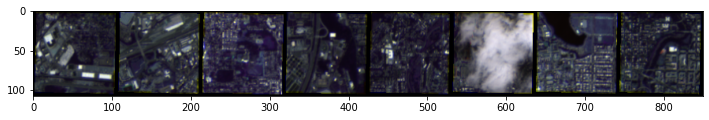

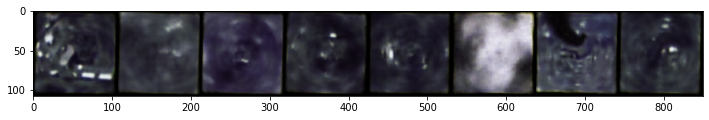

In [0]:
dataiter = iter(test_loader)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
images[:, 0, :, :] = torch.from_numpy(cv2.normalize(images[:, 0, :, :].numpy(), 
                                                    None, 0, 255, 
                                                    cv2.NORM_MINMAX, 
                                                    dtype = cv2.CV_8U) / 255.)
images[:, 1, :, :] = torch.from_numpy(cv2.normalize(images[:, 1, :, :].numpy(), 
                                                    None, 0, 255, 
                                                    cv2.NORM_MINMAX, 
                                                    dtype = cv2.CV_8U) / 255.)
images[:, 2, :, :] = torch.from_numpy(cv2.normalize(images[:, 2, :, :].numpy(), 
                                                    None, 0, 255, 
                                                    cv2.NORM_MINMAX, 
                                                    dtype = cv2.CV_8U) / 255.)
imshow(torchvision.utils.make_grid(images[0:8, :, :, :]))

_, out = model(images.to(device).double())
fig = plt.figure(figsize=(12, 8))
images2 = out.to('cpu').detach()
imshow(torchvision.utils.make_grid(images2[0:8, :, :, :]))

In [0]:
state = torch.load(BASE_DIR + "/last_mmd_vae.ckpt")
if 'model_state_dict' in state.keys():
   model.load_state_dict(state['model_state_dict'])
else:
   model.load_state_dict(state)